I am going to create a Feature Extractor - Decoder model that creates captions from images.

I'll use a pretrained model (VGG16) as image feature extractor and RNNs (LSTM) as decoder. I will explain everything as much as I can.

**Image Caption Project**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/ahmadahmadzada/images2000/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mennareda25
Your Kaggle Key: ··········


100%|██████████| 85.9M/85.9M [00:01<00:00, 53.6MB/s]


In [ ]:
# import libraries
import os
import pickle
import numpy as np
import string
from tqdm.notebook import tqdm
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers.legacy import Adam
import os
import random
import shutil
from os import listdir
from pickle import dump

In [ ]:
data= "/content/images2000/images/images"
data_paths = [os.path.join(pth, f)
    for pth, dirs, files in os.walk(data) for f in files]
data_paths

['/content/images2000/images/images/image_915.jpg',
 '/content/images2000/images/images/image_2467.jpg',
 '/content/images2000/images/images/image_405.jpg',
 '/content/images2000/images/images/image_953.jpg',
 '/content/images2000/images/images/image_1720.jpg',
 '/content/images2000/images/images/image_2468.jpg',
 '/content/images2000/images/images/image_1312.jpg',
 '/content/images2000/images/images/image_844.jpg',
 '/content/images2000/images/images/image_33.jpg',
 '/content/images2000/images/images/image_547.jpg',
 '/content/images2000/images/images/image_137.jpg',
 '/content/images2000/images/images/image_2059.jpg',
 '/content/images2000/images/images/image_99.jpg',
 '/content/images2000/images/images/image_1199.jpg',
 '/content/images2000/images/images/image_2155.jpg',
 '/content/images2000/images/images/image_2272.jpg',
 '/content/images2000/images/images/image_1341.jpg',
 '/content/images2000/images/images/image_2067.jpg',
 '/content/images2000/images/images/image_1019.jpg',
 '/

In [7]:
# path of data
path = '/content/images2000/images/images'

In [8]:
# load vgg16 model
model = VGG16 ()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [9]:
# extract features from image
features = {}
directory = os.path.join(path, )

for img_name in  tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    image_id =image_id.split('_')[1]
    # store feature
    features[image_id] = feature

  0%|          | 0/2054 [00:00<?, ?it/s]

In [10]:
features

{'915': array([[4.1651745, 3.9711485, 2.748394 , ..., 6.8537207, 0.       ,
         0.       ]], dtype=float32),
 '2467': array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         1.4190065]], dtype=float32),
 '405': array([[1.8163873 , 0.40218592, 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 '953': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 '1720': array([[0.      , 0.      , 0.      , ..., 0.      , 2.068121, 1.456167]],
       dtype=float32),
 '2468': array([[1.4564451 , 0.45519117, 0.        , ..., 0.        , 2.7912548 ,
         0.        ]], dtype=float32),
 '1312': array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 1.620699]],
       dtype=float32),
 '844': array([[2.4492896 , 0.        , 0.        , ..., 0.        , 2.6817563 ,
         0.26001817]], dtype=float32),
 '33': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 '547': array([[0.       , 0.       , 0.       , ..., 0.       , 0.    

In [12]:
# store features in pickle
WORKING_DIR= "/content/images2000/images"
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [13]:
# load features from pickle
with open(os.path.join('/content/images2000/images/features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [14]:
import pandas as pd

captions= pd.read_excel('/content/images2000/images_info.xlsx')

In [15]:
captions.drop('id',axis=1,inplace=True  )

In [16]:
captions

,image,caption
0,image_1.jpg,A beautiful young girl posing on a white backg...
1,image_4.jpg,"One hand pointing, finger out, thumb up"
2,image_6.jpg,A beautiful young girl posing with a gray back...
3,image_3.jpg,Medical stitches - puncture wound closed up
4,image_15.jpg,A happy couple
...,...,...
2049,image_2497.jpg,Illustration of businessman looking through bi...
2050,image_2499.jpg,Italian Woman Holding Sliced Pizza To Eat in a...
2051,image_2498.jpg,Young Woman in Camel Jacket and Scarf Holding ...
2052,image_2500.jpg,A man in a black tshirt talks on a cell phone ...


In [17]:
mapping = {}
for i in range(len(captions)):
  image_index= captions.image[i].split('.')[0]
  image_index = image_index.split('_')[1]
  mapping[image_index] = []
  mapping[image_index].append(captions.caption[i])


In [18]:
mapping

{'1': ['A beautiful young girl posing on a white background.'],
 '4': ['One hand pointing, finger out, thumb up'],
 '6': ['A beautiful young girl posing with a gray background.'],
 '3': ['Medical stitches - puncture wound closed up'],
 '15': ['A happy couple'],
 '11': ['Young girl dancing on stage in tutu\nThis image was shot at high ISO, only use it as is, noise removal software was used.'],
 '2': [' A man thinking with a white mask'],
 '14': ['Businessman with lightbulb head - Thinking process and ideas in a business context'],
 '10': ['Mother and baby in swimming pool'],
 '5': ['my hand compared to ancient handprints of anasazi tribes'],
 '18': ['Young boy dreams of being a superhero - Child imagination and creativity concept'],
 '8': ['Sulky and angry young kid on the couch'],
 '12': ['My Baby after bath'],
 '16': ['Woman sketching a social network on virtual screen'],
 '17': ['Nice dress (wedding)'],
 '19': ['Girls with flowers and sharee'],
 '24': ['Young woman holding purse smil

In [19]:
mapping['10']

['Mother and baby in swimming pool']

In [20]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('।', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
           # caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [21]:
# before preprocess of text
mapping['10']

['Mother and baby in swimming pool']

In [22]:
# preprocess the text
clean(mapping)

In [23]:
# after preprocess of text
mapping['10']

['mother and baby in swimming pool']

In [24]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [25]:
len(all_captions)

2054

In [26]:
all_captions[:20]

['a beautiful young girl posing on a white background.',
 'one hand pointing, finger out, thumb up',
 'a beautiful young girl posing with a gray background.',
 'medical stitches - puncture wound closed up',
 'a happy couple',
 'young girl dancing on stage in tutu\nthis image was shot at high iso, only use it as is, noise removal software was used.',
 ' a man thinking with a white mask',
 'businessman with lightbulb head - thinking process and ideas in a business context',
 'mother and baby in swimming pool',
 'my hand compared to ancient handprints of anasazi tribes',
 'young boy dreams of being a superhero - child imagination and creativity concept',
 'sulky and angry young kid on the couch',
 'my baby after bath',
 'woman sketching a social network on virtual screen',
 'nice dress (wedding)',
 'girls with flowers and sharee',
 'young woman holding purse smiles',
 'a beautiful young girl posing with a white background.',
 'a mother and her son sit by the charles river in boston, watch

In [27]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [28]:
vocab_size

2948

In [29]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

75

In [30]:
## Train Test Split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [31]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [32]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 512, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(512)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',)

# plot the model
# plot_model(model, show_shapes=True)

In [34]:
# train the model
epochs = 3
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

57/57 [==============================] - 370s 7s/step - loss: 1.7815


In [35]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
#Model Creation
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [37]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [38]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/206 [00:00<?, ?it/s]

BLEU-1: 0.039282
BLEU-2: 0.020295


In [39]:
def img_caption(image_name):
    # load the image
    # image_name = ">>.jpg"
    image_id = image_name.split('.')[0]
    image_id =image_id.split('_')[1]
    img_path = os.path.join(path,  image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('Actual:...')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('Predicted:...')
    print(y_pred)
    plt.imshow(image)

**Model Testing**

Actual:...
a beautiful young girl playing on a playground with a dog.
Predicted:...
startseq playing playing playing playing playing at a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with a playground with


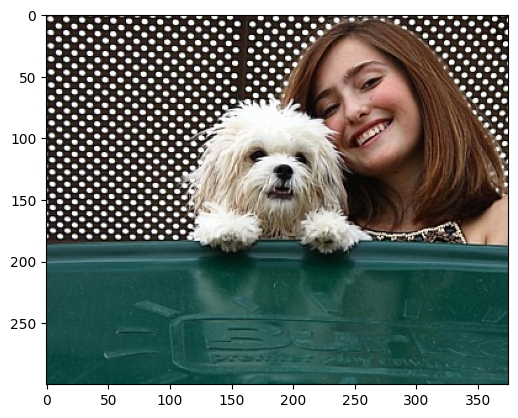

In [40]:
img_caption("image_915.jpg")

Actual:...
tedtty and michael with the horses
Predicted:...
startseq loved the the loved the the the the the turquoise turquoise turquoise turquoise turquoise turquoise turquoise turquoise the turquoise the wall at the wall of the wall of the wall of the wall of the wall of the wall of the wall of the wall of the wall of the wall of the wall of the wall of the wall of the wall of the wall of the wall of the wall of the wall


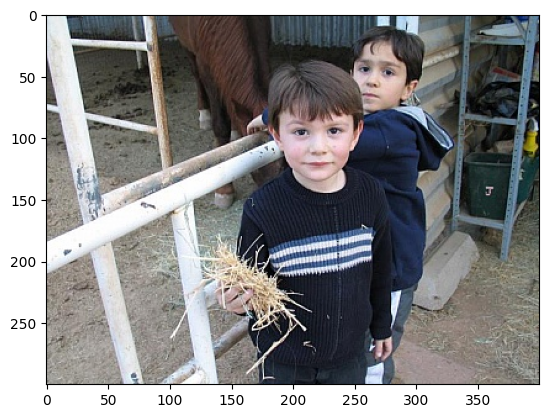

In [41]:
img_caption("image_353.jpg")

Actual:...
yoga on the beach - woman alone
Predicted:...
startseq on the beach young woman in the beach with the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in the beach in


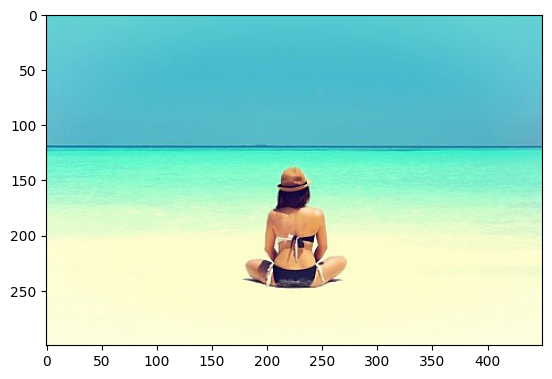

In [42]:
img_caption("image_1219.jpg")

Actual:...
person using an atm machine
Predicted:...
startseq using an atm machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a machine using a


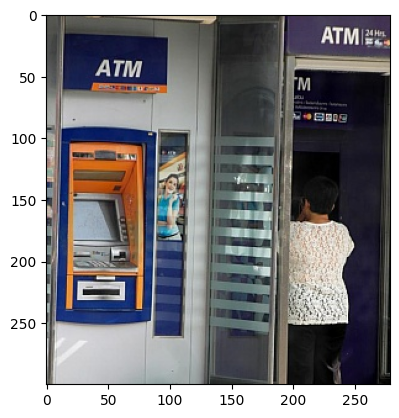

In [43]:
img_caption("image_1178.jpg")